# Lecture 12 : OpenMP Extreme

## Clone the materials repo to access datafiles.

In [ ]:
!git clone https://code.vt.edu/jasonwil/cmda3634_materials.git

Cloning into 'cmda3634_materials'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 223 (delta 59), reused 9 (delta 2), pack-reused 37 (from 1)
Receiving objects: 100% (223/223), 37.70 MiB | 10.11 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [ ]:
# copy the lecture 12 files to our working directory
!cp cmda3634_materials/L12/* .

# Part 1 : Sequential Code for Finding the Extreme Pair

In [ ]:
%%writefile extreme.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include "vec.h"

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (double* data, int len, int dim) {
    extreme_info info = { 0, -1, -1 };
    for (int i=0;i<len-1;i++) {
        for (int j=i+1;j<len;j++) {
            // data+i*dim is a pointer to the ith data point
            // data+j*dim is a pointer to the jth data point
            double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
            if (dist_sq > info.max_dist_sq) {
                info.max_dist_sq = dist_sq;
                info.extreme_1 = i;
                info.extreme_2 = j;
            }
        }
    }
    return info;
}

int main () {

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }
    vec_read_dataset (data,len,dim);

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len,dim);

    // print the results
    printf ("Extreme Distance = %.2f\n",sqrt(info.max_dist_sq));
    printf ("Extreme Pair = %d %d\n",info.extreme_1,info.extreme_2);

    // free the data matrix
    free (data);
}

Writing extreme.c


In [ ]:
!gcc -o extreme extreme.c vec.c -lm

In [ ]:
!time cat mnist1000.txt | ./extreme

Extreme Distance = 3797.52
Extreme Pair = 121 426

real	0m3.537s
user	0m2.516s
sys	0m0.014s


In [ ]:
!time cat mnist2000.txt | ./extreme

Extreme Distance = 3928.75
Extreme Pair = 1618 1895

real	0m9.604s
user	0m9.478s
sys	0m0.025s


In [ ]:
!time cat mnist10k.txt | ./extreme

Extreme Distance = 4097.95
Extreme Pair = 5977 6412

real	3m51.342s
user	3m48.513s
sys	0m0.255s


## Note that finding the extreme pair is an $O(n^2)$ algorithm.  
## For a large MNIST dataset, the sequential code takes over 3 minutes.  
## We can substantially reduce the runtime by checking for the extreme pair in parallel.

# Part 2 : OpenMP Version of Extreme

## For version 1 of the OpenMP code we will add a command line argument to read in the number of threads and add OpenMP timing code around the function call that computes the extreme pair.  

In [ ]:
%%writefile omp_extreme_v1.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>
#include "vec.h"

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (double* data, int len, int dim) {
    extreme_info info = { 0, -1, -1 };
    for (int i=0;i<len-1;i++) {
        for (int j=i+1;j<len;j++) {
            double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
            if (dist_sq > info.max_dist_sq) {
                info.max_dist_sq = dist_sq;
                info.extreme_1 = i;
                info.extreme_2 = j;
            }
        }
    }
    return info;
}

int main (int argc, char** argv) {

    // get num_threads from the command line
    if (argc < 2) {
        printf ("Command usage : %s num_threads\n",argv[0]);
        return 1;
    }
    int num_threads = atoi(argv[1]);
    omp_set_num_threads(num_threads);

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }
    vec_read_dataset (data,len,dim);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len,dim);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("Extreme Distance = %.2f\n",sqrt(info.max_dist_sq));
    printf ("Extreme Pair = %d %d\n",info.extreme_1,info.extreme_2);

    // free the data matrix
    free (data);
}

Overwriting omp_extreme_v1.c


In [ ]:
!gcc -o omp_extreme_v1 omp_extreme_v1.c vec.c -lm -fopenmp

In [ ]:
!cat mnist1000.txt | ./omp_extreme_v1 4

num_threads = 4, elapsed time = 1.6015 seconds
Extreme Distance = 3797.52
Extreme Pair = 121 426


## As we did with *omp_sum* we will next systematically transform the code to work in parallel.

## In version 2, we create a parallel region that includes the double for loop.

In [ ]:
%%writefile omp_extreme_v2.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>
#include "vec.h"

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (double* data, int len, int dim) {
    extreme_info info = { 0, -1, -1 };
#pragma omp parallel
    {
        for (int i=0;i<len-1;i++) {
            for (int j=i+1;j<len;j++) {
                double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
                if (dist_sq > info.max_dist_sq) {
                    info.max_dist_sq = dist_sq;
                    info.extreme_1 = i;
                    info.extreme_2 = j;
                }
            }
        }
    }
    return info;
}

int main (int argc, char** argv) {

    // get num_threads from the command line
    if (argc < 2) {
        printf ("Command usage : %s num_threads\n",argv[0]);
        return 1;
    }
    int num_threads = atoi(argv[1]);
    omp_set_num_threads(num_threads);

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }
    vec_read_dataset (data,len,dim);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len,dim);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("Extreme Distance = %.2f\n",sqrt(info.max_dist_sq));
    printf ("Extreme Pair = %d %d\n",info.extreme_1,info.extreme_2);

    // free the data matrix
    free (data);
}

Overwriting omp_extreme_v2.c


In [ ]:
!gcc -o omp_extreme_v2 omp_extreme_v2.c vec.c -lm -fopenmp

In [ ]:
!cat mnist1000.txt | ./omp_extreme_v2 4

num_threads = 4, elapsed time = 6.0181 seconds
Extreme Distance = 3797.52
Extreme Pair = 121 426


## For version 2 we got the correct answer but there is no speedup since all threads are now testing all of the pairs.

## In version 3, we will assign the loop iterations of the **outer loop** to threads so that each thread gets approximately the same number of **outer loop** iterations.

In [ ]:
%%writefile omp_extreme_v3.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>
#include "vec.h"

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (double* data, int len, int dim) {
    extreme_info info = { 0, -1, -1 };
#pragma omp parallel
    {
#pragma omp for
        for (int i=0;i<len-1;i++) {
            for (int j=i+1;j<len;j++) {
                double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
                if (dist_sq > info.max_dist_sq) {
                    info.max_dist_sq = dist_sq;
                    info.extreme_1 = i;
                    info.extreme_2 = j;
                }
            }
        }
    }
    return info;
}

int main (int argc, char** argv) {

    // get num_threads from the command line
    if (argc < 2) {
        printf ("Command usage : %s num_threads\n",argv[0]);
        return 1;
    }
    int num_threads = atoi(argv[1]);
    omp_set_num_threads(num_threads);

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }
    vec_read_dataset (data,len,dim);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len,dim);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("Extreme Distance = %.2f\n",sqrt(info.max_dist_sq));
    printf ("Extreme Pair = %d %d\n",info.extreme_1,info.extreme_2);

    // free the data matrix
    free (data);
}

Overwriting omp_extreme_v3.c


In [ ]:
!gcc -o omp_extreme_v3 omp_extreme_v3.c vec.c -lm -fopenmp

In [ ]:
!cat mnist1000.txt | ./omp_extreme_v3 4

num_threads = 4, elapsed time = 1.5303 seconds
Extreme Distance = 3797.52
Extreme Pair = 121 426


## Version 3 appears to compute the correct answer but we have just gotten lucky.  
## Let's next look for potential read/write race conditions that could make our code eventually fail to compute the correct answer.
## A parallel code is called **thread safe** if it **always** computes the correct answer regardless of the number of threads used.
## A parallel code with the potential for a read/write race condition (even if the probability of it happening is small) is **not thread safe**.
## In this class our goal will be to always write **thread safe** code.
## In particular, you will lose credit if your parallel code works most of the time but is not **thread safe**!

## In version 4, we specify the shared variables.
## There are four shared variables: **data**, **len**, **dim**, **info**.
## The shared variables data, len, and dim are read only.
## The shared variable info is read/write.  
## We will need to protect access to info in order to prevent read/write race conditions.

In [ ]:
%%writefile omp_extreme_v4.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>
#include "vec.h"

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (double* data, int len, int dim) {
    extreme_info info = { 0, -1, -1 };
#pragma omp parallel default(none) shared(data,len,dim,info)
    {
#pragma omp for
        for (int i=0;i<len-1;i++) {
            for (int j=i+1;j<len;j++) {
                double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
                if (dist_sq > info.max_dist_sq) {
                    info.max_dist_sq = dist_sq;
                    info.extreme_1 = i;
                    info.extreme_2 = j;
                }
            }
        }
    }
    return info;
}

int main (int argc, char** argv) {

    // get num_threads from the command line
    if (argc < 2) {
        printf ("Command usage : %s num_threads\n",argv[0]);
        return 1;
    }
    int num_threads = atoi(argv[1]);
    omp_set_num_threads(num_threads);

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }
    vec_read_dataset (data,len,dim);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len,dim);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("Extreme Distance = %.2f\n",sqrt(info.max_dist_sq));
    printf ("Extreme Pair = %d %d\n",info.extreme_1,info.extreme_2);

    // free the data matrix
    free (data);
}

Overwriting omp_extreme_v4.c


In [ ]:
!gcc -o omp_extreme_v4 omp_extreme_v4.c vec.c -lm -fopenmp

In [ ]:
!cat mnist1000.txt | ./omp_extreme_v4 4

num_threads = 4, elapsed time = 1.5110 seconds
Extreme Distance = 3797.52
Extreme Pair = 121 426


## In version 5, we create a private thread version of the read/write shared variable info.  
## **This private thread variable allows each thread to work independently throughout the entire nested for loop**.
## This allows the parallel nested for loop to run as fast as possible.

In [ ]:
%%writefile omp_extreme_v5.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>
#include "vec.h"

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (double* data, int len, int dim) {
    extreme_info info = { 0, -1, -1 };
#pragma omp parallel default(none) shared(data,len,dim,info)
    {
        extreme_info thread_info = { 0, -1, -1 };
#pragma omp for
        for (int i=0;i<len-1;i++) {
            for (int j=i+1;j<len;j++) {
                double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
                if (dist_sq > thread_info.max_dist_sq) {
                    thread_info.max_dist_sq = dist_sq;
                    thread_info.extreme_1 = i;
                    thread_info.extreme_2 = j;
                }
            }
        }
    }
    return info;
}

int main (int argc, char** argv) {

    // get num_threads from the command line
    if (argc < 2) {
        printf ("Command usage : %s num_threads\n",argv[0]);
        return 1;
    }
    int num_threads = atoi(argv[1]);
    omp_set_num_threads(num_threads);

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }
    vec_read_dataset (data,len,dim);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len,dim);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("Extreme Distance = %.2f\n",sqrt(info.max_dist_sq));
    printf ("Extreme Pair = %d %d\n",info.extreme_1,info.extreme_2);

    // free the data matrix
    free (data);
}

Writing omp_extreme_v5.c


In [ ]:
!gcc -o omp_extreme_v5 omp_extreme_v5.c vec.c -lm -fopenmp

In [ ]:
!cat mnist1000.txt | ./omp_extreme_v5 4

num_threads = 4, elapsed time = 1.4948 seconds
pairs checked = 0
Extreme Distance = 0.00
Extreme Pair = -1 -1


## The issue with version 5 is that the shared variable info is never updated!
## In version 6 each thread updates the shared info variable with its own local information inside of a **critical region**.
## The key aspect of a critical region is that **only one thread can exectute the critical region at a time**.
## This ensures that the threads can update the shared variable info without read/write race conditions.
## An OpenMP **critical region** is similar to the OpenMP **atomic construct** but it is more general.  
## In particular, **a critical region can contain an arbitrary block of C code while the atomic construct can protect only a single assignment and can only be used with specific operations**.
## Note that this code is still efficient because each thread only enters the critical region **a single time** since it is **outside** the nested for loop.

In [ ]:
%%writefile omp_extreme_v6.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>
#include "vec.h"

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (double* data, int len, int dim) {
    extreme_info info = { 0, -1, -1 };
#pragma omp parallel default(none) shared(data,len,dim,info)
    {
        extreme_info thread_info = { 0, -1, -1 };
#pragma omp for
        for (int i=0;i<len-1;i++) {
            for (int j=i+1;j<len;j++) {
                double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
                if (dist_sq > thread_info.max_dist_sq) {
                    thread_info.max_dist_sq = dist_sq;
                    thread_info.extreme_1 = i;
                    thread_info.extreme_2 = j;
                }
            }
        }
#pragma omp critical
        {
            if (thread_info.max_dist_sq > info.max_dist_sq) {
                info = thread_info;
            }
        }
    }
    return info;
}

int main (int argc, char** argv) {

    // get num_threads from the command line
    if (argc < 2) {
        printf ("Command usage : %s num_threads\n",argv[0]);
        return 1;
    }
    int num_threads = atoi(argv[1]);
    omp_set_num_threads(num_threads);

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }
    vec_read_dataset (data,len,dim);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len,dim);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("Extreme Distance = %.2f\n",sqrt(info.max_dist_sq));
    printf ("Extreme Pair = %d %d\n",info.extreme_1,info.extreme_2);

    // free the data matrix
    free (data);
}

Overwriting omp_extreme_v6.c


In [ ]:
!gcc -o omp_extreme_v6 omp_extreme_v6.c vec.c -lm -fopenmp

In [ ]:
!cat mnist1000.txt | ./omp_extreme_v6 4

num_threads = 4, elapsed time = 1.5454 seconds
Extreme Distance = 3797.52
Extreme Pair = 121 426


## Let's run version 6 on matrix with num_threads set to 1, 2, and 4.
## Note that although we get the correct answers the timing results are a bit disappointing!

    $ gcc -o omp_extreme omp_extreme.c vec.c -lm -fopenmp
    $ cat mnist1000.txt | ./omp_extreme 1
    num_threads = 1, elapsed time = 1.0713 seconds
    Extreme Distance = 3797.52
    Extreme Pair = 121 426
    $ cat mnist1000.txt | ./omp_extreme 2
    num_threads = 2, elapsed time = 0.8031 seconds
    Extreme Distance = 3797.52
    Extreme Pair = 121 426
    $ cat mnist1000.txt | ./omp_extreme 4
    num_threads = 4, elapsed time = 0.4821 seconds
    Extreme Distance = 3797.52
    Extreme Pair = 121 426


## The speedup for 2 threads is $1.0713/0.8031 = 1.33$ but the ideal speedup is $2$.
## The speedup for 4 threads is $1.0713/0.4821 = 2.22$ but the ideal speedup is $4$.

## In version 7, we add some diagnostic code to try to determine why the code does not give us near the ideal speedup for num_threads = 2 and num_threads = 4.
## In particular, we have each thread print out the number of pairs tested.  Since each pair takes about the same amount of work to test, the number of pairs tested gives us a good approximation for the amount of work being done by each thread.

In [ ]:
%%writefile omp_extreme_v7.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>
#include "vec.h"

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (double* data, int len, int dim) {
    extreme_info info = { 0, -1, -1 };
#pragma omp parallel default(none) shared(data,len,dim,info)
    {
        extreme_info thread_info = { 0, -1, -1 };
#ifdef DIAG
        int thread_pairs_checked = 0;
#endif
#pragma omp for
        for (int i=0;i<len-1;i++) {
            for (int j=i+1;j<len;j++) {
#ifdef DIAG
                thread_pairs_checked += 1;
#endif
                double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
                if (dist_sq > thread_info.max_dist_sq) {
                    thread_info.max_dist_sq = dist_sq;
                    thread_info.extreme_1 = i;
                    thread_info.extreme_2 = j;
                }
            }
        }
#ifdef DIAG
        int thread_num = omp_get_thread_num();
        printf ("thread %d checked %d pairs\n",thread_num,thread_pairs_checked);
#endif
#pragma omp critical
        {
            if (thread_info.max_dist_sq > info.max_dist_sq) {
                info = thread_info;
            }
        }
    }
    return info;
}

int main (int argc, char** argv) {

    // get num_threads from the command line
    if (argc < 2) {
        printf ("Command usage : %s num_threads\n",argv[0]);
        return 1;
    }
    int num_threads = atoi(argv[1]);
    omp_set_num_threads(num_threads);

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }
    vec_read_dataset (data,len,dim);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len,dim);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("Extreme Distance = %.2f\n",sqrt(info.max_dist_sq));
    printf ("Extreme Pair = %d %d\n",info.extreme_1,info.extreme_2);

    // free the data matrix
    free (data);
}

Writing omp_extreme_v7.c


## Here are the results running version 7 on matrix.
    $ gcc -DDIAG -o omp_extreme omp_extreme.c vec.c -lm -fopenmp
    $ cat mnist1000.txt | ./omp_extreme 1
    thread 0 checked 499500 pairs
    num_threads = 1, elapsed time = 1.0709 seconds
    Extreme Distance = 3797.52
    Extreme Pair = 121 426
    $ cat mnist1000.txt | ./omp_extreme 2
    thread 0 checked 374750 pairs
    thread 1 checked 124750 pairs
    num_threads = 2, elapsed time = 0.8030 seconds
    Extreme Distance = 3797.52
    Extreme Pair = 121 426
    $ cat mnist1000.txt | ./omp_extreme 4
    thread 0 checked 218625 pairs
    thread 3 checked 31125 pairs
    thread 1 checked 156125 pairs
    thread 2 checked 93625 pairs
    num_threads = 4, elapsed time = 0.4819 seconds
    Extreme Distance = 3797.52
    Extreme Pair = 121 426


## We can now see the problem.  
## For the num_threads = 4 case, thread 0 is checking 218625 pairs while thread 3 is checking only 31125 pairs.
## Since the parallel region cannot exit until all threads finish their assigned work, some threads endup **idle** waiting for other threads to finish.
## The problem of ensuring that all threads do around the same amount of work in parallel computing is called **load balancing**.
## In this case the OpenMP loop scheduler is doing a poor job of **load balancing** because the nested for loop is **triangular**.
## In particular, the number of inner loop iterations depends on *i*.  As *i* increases, the number of inner loop iterations decreases.
## Thus in the case num_threads = 4, thread 0 which is assigned the small values of *i* ends up doing the most amount of work and thread 3 which is assigned the large values of *i* ends of doing the least amount of work.  


## Fortunately, OpenMP has the **collapse(k)** clause that we can use to fix this problem.
## Simply put, the **collapse(k)** clause transforms a nested for loop with k loops into a large single for loop and the iterations of the single for loop are divided so that each thread gets roughly the same number of iterations.
## As an example the triangular nested loop
    for (int i=0;i<3;i++) {
        for (int j=i+1;j<4;j++) {
            printf ("%d %d\n",i,j);
        }
    }
## which prints
    0 1
    0 2
    0 3
    1 2
    1 3
    2 3
## is collapsed into something like
    for (int p=0;p<6;p++) {
        printf ("%d %d\n",pairs[p].i,pairs[p].j);
    }

## For our final version 8 we add the collapse(2) clause since we have a double for loop.

In [ ]:
%%writefile omp_extreme_v8.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>
#include "vec.h"

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (double* data, int len, int dim) {
    extreme_info info = { 0, -1, -1 };
#pragma omp parallel default(none) shared(data,len,dim,info)
    {
        extreme_info thread_info = { 0, -1, -1 };
#ifdef DIAG
        int thread_pairs_checked = 0;
#endif
#pragma omp for collapse(2)
        for (int i=0;i<len-1;i++) {
            for (int j=i+1;j<len;j++) {
#ifdef DIAG
                thread_pairs_checked += 1;
#endif
                double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
                if (dist_sq > thread_info.max_dist_sq) {
                    thread_info.max_dist_sq = dist_sq;
                    thread_info.extreme_1 = i;
                    thread_info.extreme_2 = j;
                }
            }
        }
#ifdef DIAG
        int thread_num = omp_get_thread_num();
        printf ("thread %d checked %d pairs\n",thread_num,thread_pairs_checked);
#endif
#pragma omp critical
        {
            if (thread_info.max_dist_sq > info.max_dist_sq) {
                info = thread_info;
            }
        }
    }
    return info;
}

int main (int argc, char** argv) {

    // get num_threads from the command line
    if (argc < 2) {
        printf ("Command usage : %s num_threads\n",argv[0]);
        return 1;
    }
    int num_threads = atoi(argv[1]);
    omp_set_num_threads(num_threads);

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }
    vec_read_dataset (data,len,dim);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len,dim);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("Extreme Distance = %.2f\n",sqrt(info.max_dist_sq));
    printf ("Extreme Pair = %d %d\n",info.extreme_1,info.extreme_2);

    // free the data matrix
    free (data);
}

Writing omp_extreme_v8.c


## Here are the results when running version 8 on matrix.

    $ gcc -DDIAG -o omp_extreme omp_extreme.c vec.c -lm -fopenmp
    $ cat mnist1000.txt | ./omp_extreme 1
    thread 0 checked 499500 pairs
    num_threads = 1, elapsed time = 1.0712 seconds
    Extreme Distance = 3797.52
    Extreme Pair = 121 426
    $ cat mnist1000.txt | ./omp_extreme 2
    thread 0 checked 249750 pairs
    thread 1 checked 249750 pairs
    num_threads = 2, elapsed time = 0.5422 seconds
    Extreme Distance = 3797.52
    Extreme Pair = 121 426
    $ cat mnist1000.txt | ./omp_extreme 4
    thread 0 checked 124875 pairs
    thread 2 checked 124875 pairs
    thread 3 checked 124875 pairs
    thread 1 checked 124875 pairs
    num_threads = 4, elapsed time = 0.2918 seconds
    Extreme Distance = 3797.52
    Extreme Pair = 121 426


## We note that each thread is now checking the same number of pairs!
## The speedup for 2 threads is now $1.0712/0.5422 = 1.98$ with an ideal speedup of $2$.
## The speedup for 4 threads is $1.0712/0.2918 = 3.67$ with an ideal speedup of $4$.

# Part 3 : Strong Scaling Studies

## *Definitions:*
### **Speedup** = $\frac{\text{seconds for 1 core}}{\text{seconds for k cores}}$
### A **Strong Scaling Study** shows how the speedup varies with the number of cores for a **fixed problem size**.

## In this part we will use strong scaling studies to compare speedup with and without the OpenMP **collapse** clause.

## Here is our final OpenMP extreme code with a few additional compile options added (loop collapse and timing).

In [6]:
%%writefile omp_extreme.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>
#include "vec.h"

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (double* data, int len, int dim) {
    extreme_info info = { 0, -1, -1 };
#pragma omp parallel default(none) shared(len,dim,data,info)
    {
        extreme_info thread_info;
#ifdef COLLAPSE
#pragma omp for collapse(2)
#else
#pragma omp for
#endif
        for (int i=0;i<len-1;i++) {
            for (int j=i+1;j<len;j++) {
                double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
                if (dist_sq > thread_info.max_dist_sq) {
                    thread_info.max_dist_sq = dist_sq;
                    thread_info.extreme_1 = i;
                    thread_info.extreme_2 = j;
                }
            }
        }
#pragma omp critical
        {
            if (thread_info.max_dist_sq > info.max_dist_sq) {
                info = thread_info;
            }
        }
    }
    return info;
}

int main (int argc, char** argv) {

    // get num_threads from the command line
    if (argc < 2) {
        printf ("Command usage : %s num_threads\n",argv[0]);
        return 1;
    }
    int num_threads = atoi(argv[1]);
    omp_set_num_threads(num_threads);

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }
    vec_read_dataset (data,len,dim);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len,dim);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
#ifdef TIMING
    printf ("(%d,%.4f),",num_threads,end_time-start_time);
#else
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("Extreme Distance = %.2f\n",sqrt(info.max_dist_sq));
    printf ("Extreme Pair = %d %d\n",info.extreme_1,info.extreme_2);
#endif

    // free the data matrix
    free (data);
}

Overwriting omp_extreme.c


## Here is a shell script that generates timing output without the collapse clause.

In [7]:
%%writefile study.sh
# compile with TIMING flag
gcc -DTIMING -o omp_extreme omp_extreme.c vec.c -lm -fopenmp

# run with 1, 2, 4, 8, 16, and 32 threads
cat $1 | ./omp_extreme 1
cat $1 | ./omp_extreme 2
cat $1 | ./omp_extreme 4
cat $1 | ./omp_extreme 8
cat $1 | ./omp_extreme 16
cat $1 | ./omp_extreme 32

# output a newline
echo

Overwriting study.sh


## Running this script on matrix generates the following output.
    $ bash study.sh mnist2000.txt
    (1,4.2885),(2,3.2135),(4,1.9244),(8,1.0611),(16,0.5587),(32,0.2918),

## Here is some Python code for plotting the ideal speedup versus the actual speedup for different thread counts.

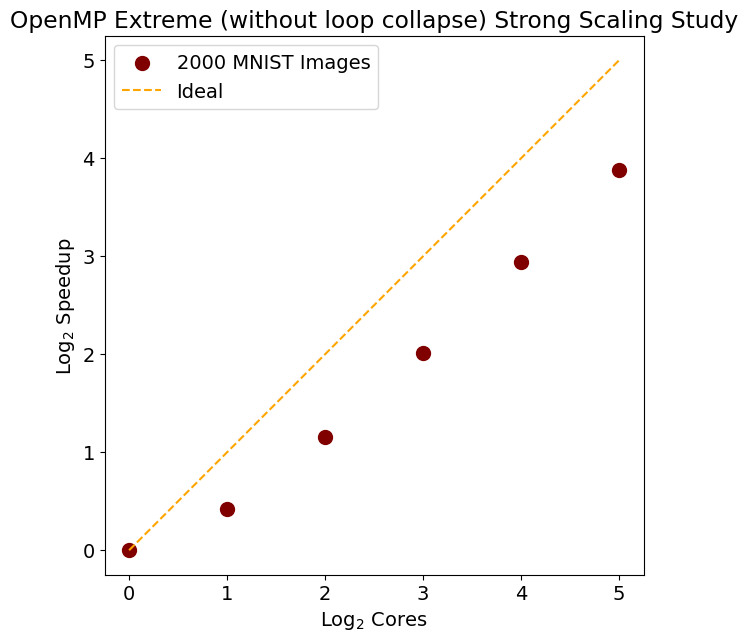

In [8]:
import numpy as np
import matplotlib.pyplot as plt
A = np.array ( ( (1,4.2885),(2,3.2135),(4,1.9244),(8,1.0611),(16,0.5587),(32,0.2918) ) )
slow_time = A[0,1]
A[:,1] = slow_time/A[:,1]
plt.rcParams['figure.figsize'] = (7, 7)
plt.rcParams.update({'font.size': 14})
plt.gca().set_aspect('equal')
plt.scatter (np.log2(A[:,0]),np.log2(A[:,1]),color='maroon',s=100,label='2000 MNIST Images')
plt.plot ([0,5],[0,5],'--',color='orange',label='Ideal')
plt.title ('OpenMP Extreme (without loop collapse) Strong Scaling Study')
plt.xlabel ('Log$_2$ Cores')
plt.ylabel ('Log$_2$ Speedup')
plt.legend();

## Here is a shell script that generates timing output without the collapse clause.

In [9]:
%%writefile study2.sh
# compile with TIMING and COLLAPSE flags
gcc -DTIMING -DCOLLAPSE -o omp_extreme omp_extreme.c vec.c -lm -fopenmp

# run with 1, 2, 4, 8, 16, and 32 threads
cat $1 | ./omp_extreme 1
cat $1 | ./omp_extreme 2
cat $1 | ./omp_extreme 4
cat $1 | ./omp_extreme 8
cat $1 | ./omp_extreme 16
cat $1 | ./omp_extreme 32

# output a newline
echo

Overwriting study2.sh


## Running this script on matrix generates the following output.
    $ bash study2.sh mnist2000.txt
    (1,4.2854),(2,2.1488),(4,1.1428),(8,0.5880),(16,0.3009),(32,0.1602),

## Here is some Python code for plotting the ideal speedup versus the actual speedup for different thread counts.

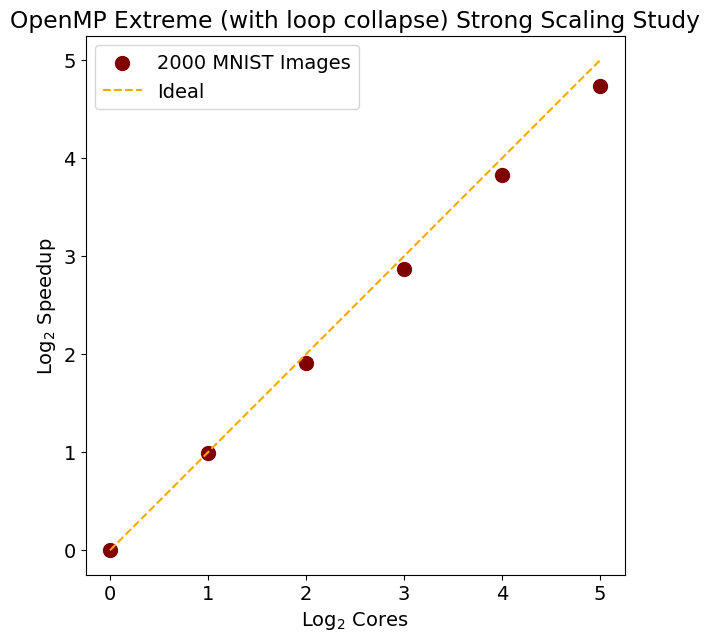

In [10]:
import numpy as np
import matplotlib.pyplot as plt
A = np.array ( ( (1,4.2854),(2,2.1488),(4,1.1428),(8,0.5880),(16,0.3009),(32,0.1602) ) )
slow_time = A[0,1]
A[:,1] = slow_time/A[:,1]
plt.rcParams['figure.figsize'] = (7, 7)
plt.rcParams.update({'font.size': 14})
plt.gca().set_aspect('equal')
plt.scatter (np.log2(A[:,0]),np.log2(A[:,1]),color='maroon',s=100,label='2000 MNIST Images')
plt.plot ([0,5],[0,5],'--',color='orange',label='Ideal')
plt.title ('OpenMP Extreme (with loop collapse) Strong Scaling Study')
plt.xlabel ('Log$_2$ Cores')
plt.ylabel ('Log$_2$ Speedup')
plt.legend();